# This script is used to explore flow events for @212042

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
# Define dir and site
site = '212042'
fig_dir = f'../output/figs/{site}/'
date_postfire = pd.to_datetime('2020-01-17')
freq = 'Hourly'

## 1 Data processing and formating

In [7]:
# Process data to format that R package requires for storm event separation.
fn = f'../data/{site}_{freq}.csv'
output_fn = f'../output/{site}_{freq}.csv'
# Read the formated file if it exists.
if os.path.exists(output_fn):
    cq_data = pd.read_csv(output_fn, index_col = 'id')
else: #Generate the formated file if it does not exist.
    cols = ['Rainfall (mm)', 'Discharge (ML/d)', 'Turbidity (NTU)'] # site 212058 does not have rainfall data from the web. 'Rainfall (mm)', 
    cq_data = pd.read_csv(fn, index_col = 'Date and time', skiprows = 3, usecols = [0, 1, 3, 5])
    cq_data.rename(columns={cq_data.columns[ii]: cols[ii] for ii in range(len(cols))}, inplace = True)
    cq_data.index.name = 'Datetime'
    # Process data
    # Drop rows if Turbidity is of value NaN
    cq_data.dropna(axis = 0, how = 'any', inplace = True)
    cq_data.index = pd.to_datetime(cq_data.index, dayfirst = True)
    cq_data.reset_index(inplace=True)
    cq_data['Discharge (cms)'] = round(cq_data['Discharge (ML/d)'] * 1e3 / 86400, 3)
    cq_data.to_csv(f'../output/{site}_{freq}.csv', index_label='id')

## 2. Plots show start of postfire for each catchment.
Timeseries is trimmed for this purpose.

### 2.1 Plot for 212042

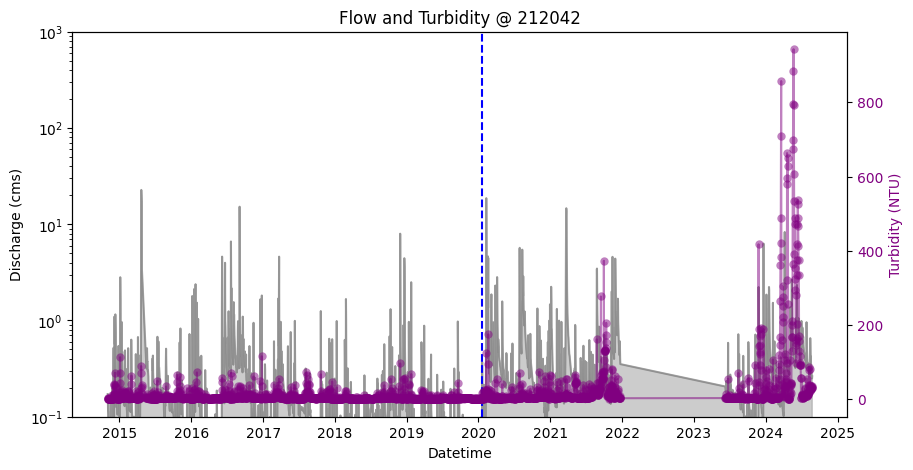

In [7]:
# Set up the figure and axes
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# convert Datatime column to datetime format
cq_data['Datetime'] = pd.to_datetime(cq_data['Datetime'], format="%d/%m/%Y") #  %H:%M
# cq_plot = cq_data[(cq_data['Datetime'] < '2020-5-30') & (cq_data['Datetime'] > '2019-8-01')]
cq_plot = cq_data
cols = cq_plot.columns
# Plot rainfall using Seaborn
plt.title(f'Flow and Turbidity @ {site}')
# Plot discharge using Seaborn
sns.lineplot(x=cols[0], y=cols[4], data=cq_plot, ax=ax1, color='grey', alpha=0.7)
# Fill the area below the line
ax1.fill_between(cq_plot[cols[0]], cq_plot[cols[4]], color='grey',  alpha=0.4)
plt.yscale('log')
ax1.set_ylabel(cols[4], color='black')
ax1.set_ylim(0.1, 1e3)
ax1.tick_params(axis='y', labelcolor='black')
# Create a second y-axis for rainfall
ax2 = ax1.twinx()

# Plot Turbidity using Seaborn
sns.lineplot(x=cols[0], y=cols[3], data=cq_plot, ax=ax2, color='purple', marker='o', \
            markeredgecolor='none', alpha = 0.5)
ax2.set_ylabel(cols[3], color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Add a horizontal line at a specific y-value (for example, y = 5)
# ax1.axhline(y=10, color='grey', linestyle='--', label='Threshold Line')
ax1.axvline(x=pd.to_datetime('2020-01-17'), color='blue', linestyle='--', label='Threshold Line')
# Adding a title

# Show the plot
plt.savefig(f'{fig_dir}{site}_{freq}_CQ_whole_timeseries.png', bbox_inches = 'tight', dpi=300, format = 'png')

## 1-0 Plot event duration and peak flow distribution.

In [5]:
# Read the StormEventSummaryData
storm_summary = pd.read_csv('../output/CQ_analysis/212042/' + \
                            '212042_NTU_StormEventSummaryData.csv', index_col = 'id')


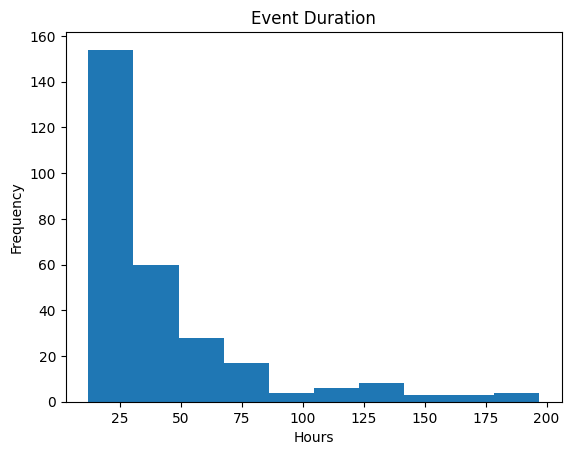

In [10]:
# Hist plot of Event Duration (Hours)
storm_summary.duration_hrs.plot(kind='hist')
plt.xlabel('Hours')
plt.title('Event Duration')
plt.savefig(f'{fig_dir}EventDurationHrs.png', format = 'png', dpi=300)

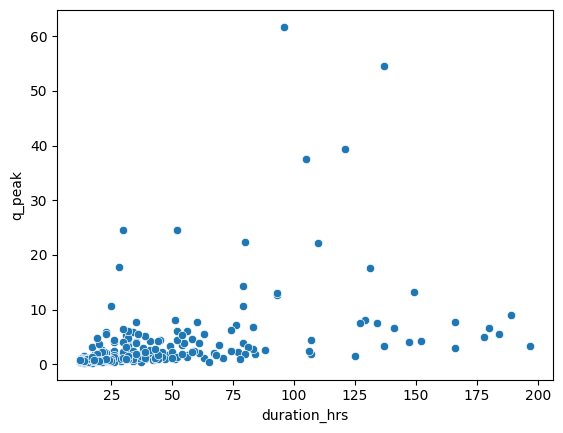

In [11]:
# Scatter plot of Event Duration and Peakflow
sns.scatterplot(data=storm_summary, x = 'duration_hrs', y = 'q_peak')
plt.savefig(f'{fig_dir}EventDurationVsPeakFLow.png', format = 'png', dpi=300)

## 1-1 Explore C-Q for pre and post fire periods


In [6]:
from functions import plot_storm_cq

In [17]:
# Read storm event data
freq = 'Daily'
Q_thre = 0.5
storm_data = pd.read_csv('../output/CQ_analysis/212042/' + f'DailyQ_above_{Q_thre}_212042_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
site = 212042
x_lab = cols[4]
y_lab = cols[3]

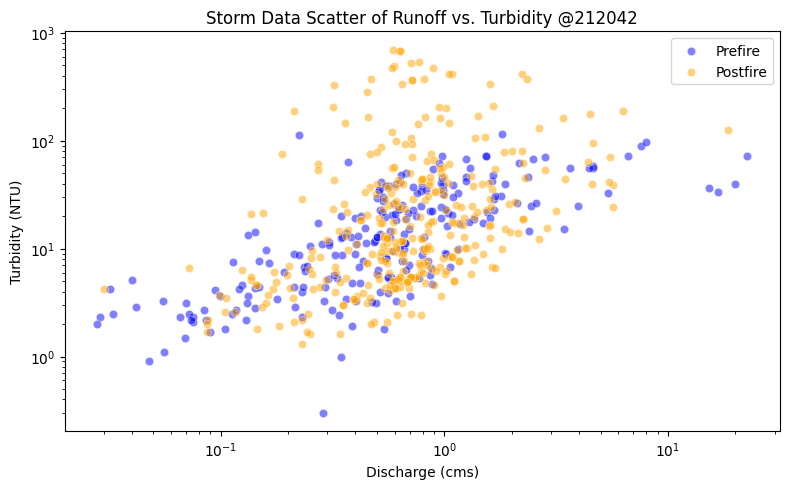

In [21]:
# Scatter plot
plot_storm_cq(storm_data, x_lab, y_lab, freq, site, date_postfire, Q_thre, colors = ['blue', 'orange'], marker='o', \
                  alpha = 0.5, labels = ['Prefire', 'Postfire'])

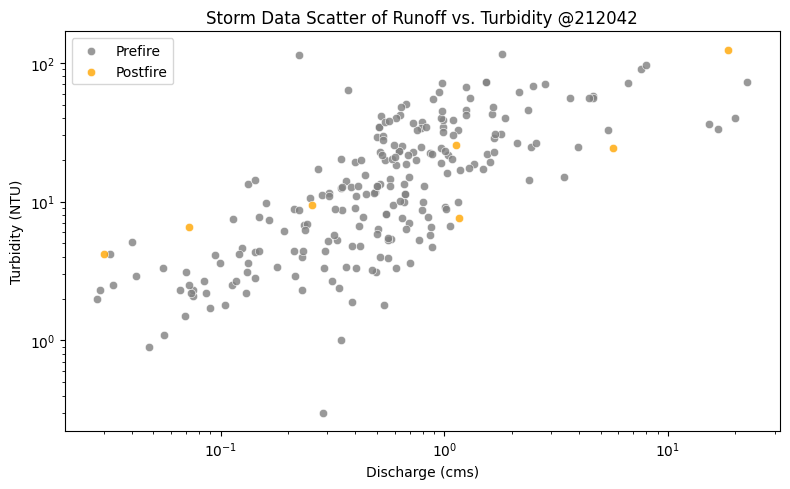

In [20]:
# Scatter plot with colors distinguished between events.
# Scatter plot using HOURLY data
# Read storm event data
Q_thre = 10
storm_data_post = pd.read_csv('../output/CQ_analysis/212042/' + f'DailyQ_above_{Q_thre}_212042_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data_post.columns
storm_data_post['Datetime'] = pd.to_datetime(storm_data_post['Datetime'])
df_temp = storm_data_post[(storm_data_post['Datetime'] >= date_postfire) & (storm_data_post['stormID'] == 154)]
data_comb = pd.concat([storm_data[storm_data['Datetime'] < date_postfire], df_temp])

# Scatter plot
plot_storm_cq(data_comb, x_lab, y_lab, freq, site, date_postfire, 'comb', colors = ['grey', 'orange'], marker='o', \
                  alpha = 0.8, labels = ['Prefire', 'Postfire'])

# 1-2 Create hysteresis for event Q-NTU

In [ ]:
import matplotlib.cm as cm

# Read storm event summary data

# Sample data creation (You can replace this with your actual time series data)
# Normalize the time for color mapping
df = storm_data
norm = plt.Normalize(df['Datetime'].min().timestamp(), df['Datetime'].max().timestamp())
colors = cm.viridis(norm(df['Datetime'].map(pd.Timestamp.timestamp)))

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plotting the hysteresis loop with color changing according to time
for i in range(len(df) - 1):
    plt.plot(df['flow'].iloc[i:i + 2], df['pollutant_concentration'].iloc[i:i + 2], 
             color=colors[i], marker='o')

# Adding a colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Time')

# Adding titles and labels
plt.title('Hysteresis between Flow and NTU')
plt.xlabel('Flow (units)')
plt.ylabel('Pollutant Concentration (units)')
plt.grid()
plt.show()